In [1]:
"""cifar_100tl.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.c om/drive/1f5Vu-ZkMtnS_KGN4b7nK1A9j1Cpjvgit

## Using Resnet50 for Transfer Learning and classify the Cifar - 100 data

### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images
"""

'cifar_100tl.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1f5Vu-ZkMtnS_KGN4b7nK1A9j1Cpjvgit\n\n## Using Resnet50 for Transfer Learning and classify the Cifar - 100 data\n\n### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input


## Importing the Cifar 100 Dataset

In [4]:
cifar100 = tf.keras.datasets.cifar100
(X_train, y_train), (X_test,y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [5]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [6]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


##  Plotting some images from the dataset

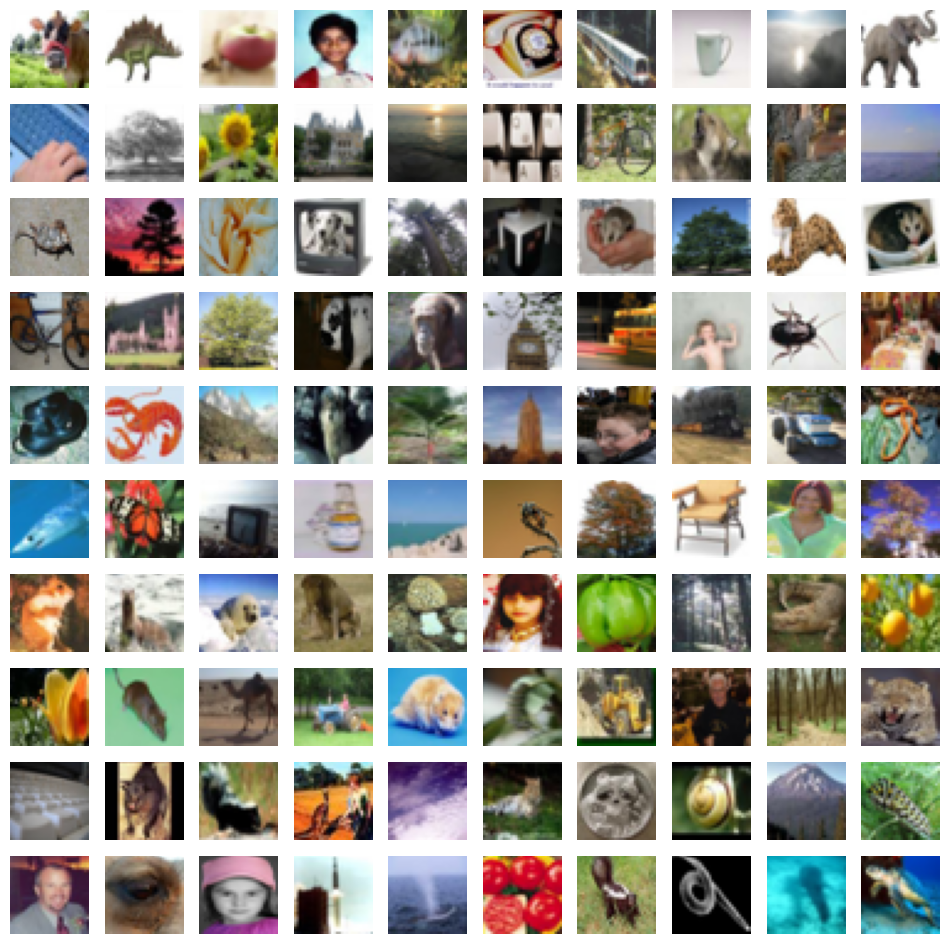

In [7]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

## Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [9]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

##  Onehot encoding of the outputs

In [10]:
y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

In [11]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


##  Image Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(X_train)

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen.fit(X_val)

##  Importing the Resnet Model

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classes = 100
)


for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


##  Converting the output layer as per our dataset

In [15]:
# Add your ResNet and subsequent layers
model = Sequential()
model.add(UpSampling2D(size=(7, 7), input_shape=(32, 32, 3)))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

# Compile the model
model.build(input_shape=(None, 224, 224, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

# Define callbacks
checkpoint = ModelCheckpoint("/content/Colab_Notebooks/cifar10_model.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.0001,
                          patience=7,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               6

Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks
* ### 32 * 7 = 224



In [16]:
History = model.fit(train_datagen.flow(X_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=X_train.shape[0] // 64,
                                  epochs=10,
                                  verbose=1,
                                  validation_data=(X_val, y_val),
                                  callbacks=[checkpoint, earlystop, reduce_lr]
)
model.save("Cifar100.h5")
model.save("/content/drive/MyDrive/machine learning.h5")

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 3.1275 - accuracy: 0.2533
Epoch 1: val_accuracy improved from -inf to 0.05580, saving model to /content/Colab_Notebooks/cifar10_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 389s 569ms/step - loss: 3.1275 - accuracy: 0.2533 - val_loss: 5.1932 - val_accuracy: 0.0558 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 1.8262 - accuracy: 0.5016
Epoch 2: val_accuracy improved from 0.05580 to 0.57820, saving model to /content/Colab_Notebooks/cifar10_model.h5
625/625 [==============================] - 356s 570ms/step - loss: 1.8262 - accuracy: 0.5016 - val_loss: 1.4692 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 1.4863 - accuracy: 0.5848
Epoch 3: val_accuracy improved from 0.57820 to 0.63410, saving model to /content/Colab_Notebooks/cifar10_model.h5
625/625 [==============================] - 356s 569ms/step - loss: 1.4863 - accuracy: 0.5848 - val_loss: 1.2479 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 1.3035 - accuracy: 0.6295
Epoch 4: val_accuracy improved from 0.63

## Plot accuracy and Loss

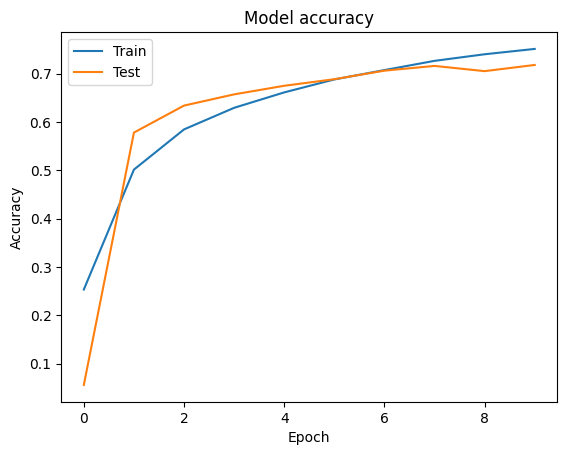

In [17]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

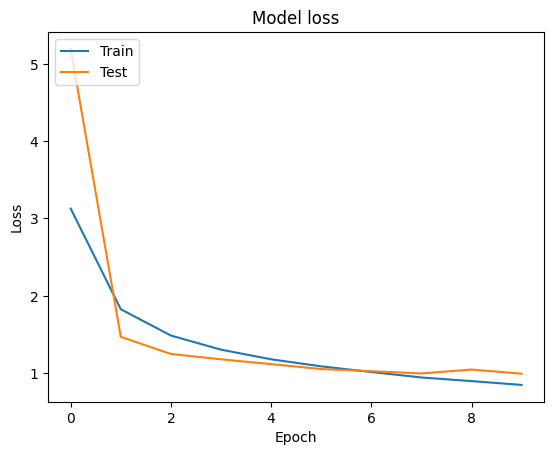

In [18]:
# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions,Accuracy and Confusion Matrix

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_pred.shape,y_test.shape)

313/313 [==============================] - 31s 95ms/step
(10000,) (10000, 100)


In [20]:
# X_test.shape

In [21]:
from sklearn.metrics import accuracy_score

# Convert one-hot encoded y_test to categorical labels
y_test = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.721


In [22]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[90,  0,  0, ...,  0,  0,  0],
       [ 0, 73,  0, ...,  0,  0,  0],
       [ 0,  0, 50, ...,  0,  4,  0],
       ...,
       [ 0,  0,  0, ..., 64,  1,  0],
       [ 0,  0,  2, ...,  0, 51,  0],
       [ 0,  0,  0, ...,  0,  0, 78]])

In [8]:
# Define the class names for CIFAR-100
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [9]:
# Print class label names along with their corresponding class indices
for index, label_name in enumerate(cifar100_class_names):
   classes=  print(f"{index}: {label_name}")
print(classes)

0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: crab
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank
86: telephone
87: television
88: tiger
89: t

In [3]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt

In [4]:
# Load your pre-trained model
model = load_model('/content/drive/MyDrive/machine learning.h5')

In [43]:
# Load and preprocess the test image
test_img = cv2.imread('/content/viber_image_2023-11-07_20-09-52-422 (1).jpg')
img = cv2.resize(test_img, (32, 32), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 32, 32, 3))
img = img / 255.0

In [44]:
# Make predictions
pred = model.predict(img)
class_num = np.argmax(pred)

1/1 [==============================] - 0s 338ms/step


In [45]:

# Get the predicted class name
predicted_class_name = cifar100_class_names[class_num]

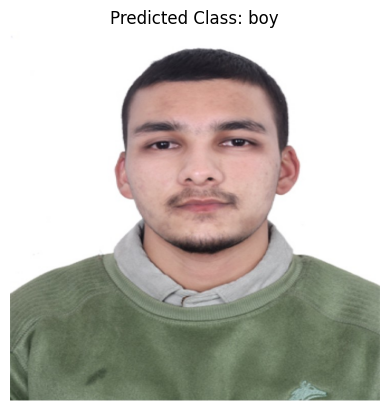

In [46]:

# Display the image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')  # Hide axis
plt.show()

In [47]:
# Print the predicted class name
print("The predicted class = ", predicted_class_name)

The predicted class =  boy
